# 04. PyTorch Custom Datasets

We've used some datasets with PyTorch before.

But how do we `get our own data` into PyTorch?

One of the ways to do so is via `Custom Datasets`

We are going to build `FoodVision Mini` in this chapter.

## What we're going to cover

1. Getting a `custom dataset` with PyTorch
2. `Becoming one with the data` - preparing and visualizing
3. `Transforming data` for use with a model
4. `Loading custom data` with pre-built functions and custom functions
5. Building `FoodVision Mini` to classify food images.
6. Comparing models with and without `data augmentation`
7. `Making predictions` on custom data.

## 0. Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn


device = 'gpu' if torch.cuda.is_available() else 'cpu'

print('PyTorch version: ', torch.__version__)
print('Available device: ', device)

PyTorch version:  2.2.2
Available device:  cpu


## 1. Get data

Our dataset is a subset of the `Food101 dataset`.

Food101 dataset has 101 different classes of food with 1000 images per class(750 training, 250 testing)

`Our dataset` stars with `3 classes of food` and only `10% of the images(~75 training, 25 testing)`

`Why do this?`

When `starting` out ML projects, it's important to try things on a `small` scale and then `increase` the scale `when necessary`.

`The whole point is to spped up the experiment`

In [2]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# if image folder doesn't exist, download and prepare it
if image_path.is_dir():
    print(f'{image_path} directory already exists. Skipping download')
else:
    print(f'{image_path} does not exist, creating one...')
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
data_url = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip'
data_file_name = data_url.split('/')[-1]
download_file_path = data_path / data_file_name # 'pizza_steak_sushi.zip'

with open(download_file_path, 'wb') as f:
    request = requests.get(data_url)
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(download_file_path, 'r') as zip_ref:
    print('Unzipping the data')
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists. Skipping download
Unzipping the data


In [3]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [4]:
# Path(glob.glob(f'{str(train_dir)}/*/*')[0]).parent.stem

### 2.1 Visualizing the image

1. Get all of the images paths
2. pick random image path using Python's random.choice()
3. Get the image class name using `pathlib.path.parent.stem`
4. Open the image with Python's PIL
5. Show the image and print metadata.

300
data/pizza_steak_sushi/test/steak/894825.jpg
Random Image path: data/pizza_steak_sushi/test/steak/894825.jpg
Image class: steak
Image height: 512
Image width: 512


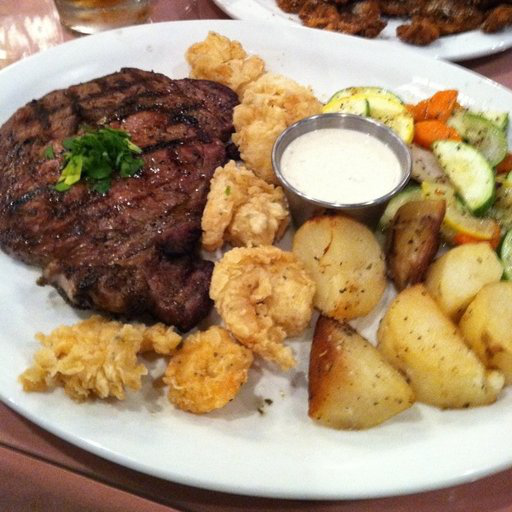

In [5]:
import random
from PIL import Image
from IPython import display

# set seed
# random.seed(42)

# 1. Get all the images paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
print(len(image_path_list))

# 2. pick a random image path

random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
image_class

# 4. Open Image
img = Image.open(random_image_path)

# # 5. Print metadata
print(f'Random Image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

### 2.2 Visualizing with Matplotlib

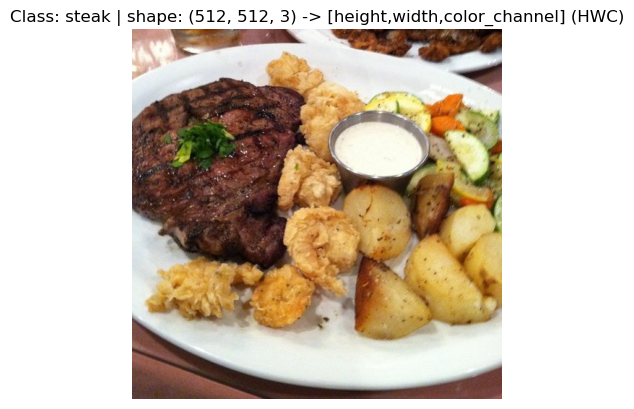

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into array
images_as_array = np.asarray(img)

# plt.figure(figsize=(10,7))
plt.imshow(images_as_array);
plt.title(f'Class: {image_class} | shape: {images_as_array.shape} -> [height,width,color_channel] (HWC)')
plt.axis(False);

In [7]:
images_as_array

array([[[184, 136, 132],
        [188, 140, 136],
        [194, 145, 140],
        ...,
        [ 24,  10,   9],
        [ 26,  15,  13],
        [ 29,  18,  16]],

       [[185, 136, 131],
        [184, 135, 130],
        [184, 135, 128],
        ...,
        [ 24,  10,   9],
        [ 25,  14,  12],
        [ 27,  16,  14]],

       [[192, 143, 136],
        [187, 138, 131],
        [183, 135, 125],
        ...,
        [ 21,   7,   4],
        [ 21,   7,   4],
        [ 21,   7,   4]],

       ...,

       [[ 91,  66,  61],
        [ 92,  67,  62],
        [ 93,  66,  59],
        ...,
        [154,  92,  81],
        [151,  89,  76],
        [150,  86,  74]],

       [[ 89,  64,  59],
        [ 93,  65,  61],
        [ 91,  64,  57],
        ...,
        [153,  91,  80],
        [152,  88,  76],
        [151,  88,  73]],

       [[ 88,  63,  58],
        [ 92,  64,  60],
        [ 88,  61,  54],
        ...,
        [153,  91,  78],
        [152,  89,  74],
        [150,  87,  72]]

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical represenation of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1. Transforming data with `torchvision.transforms`

In [9]:
# write a transform for image
data_transforms = transforms.Compose([
    # resize our image to 64x64
    transforms.Resize(size=(64,64)),
    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),

    # convert to tensor
    transforms.ToTensor()
])

# transform the img we loaded before
data_transforms(img)

tensor([[[0.1804, 0.1686, 0.0902,  ..., 0.7922, 0.7686, 0.7569],
         [0.3804, 0.4078, 0.2667,  ..., 0.8078, 0.7882, 0.7804],
         [0.3294, 0.3725, 0.3412,  ..., 0.8588, 0.8667, 0.8431],
         ...,
         [0.4275, 0.4314, 0.4275,  ..., 0.4000, 0.3922, 0.3765],
         [0.4588, 0.4510, 0.4510,  ..., 0.3569, 0.3569, 0.3451],
         [0.5333, 0.4863, 0.4667,  ..., 0.3490, 0.3529, 0.3490]],

        [[0.0902, 0.0863, 0.0392,  ..., 0.5686, 0.5569, 0.5608],
         [0.1882, 0.2078, 0.1333,  ..., 0.6157, 0.6039, 0.5961],
         [0.1725, 0.1843, 0.1725,  ..., 0.7098, 0.7255, 0.6980],
         ...,
         [0.2353, 0.2431, 0.2431,  ..., 0.2588, 0.2471, 0.2431],
         [0.2549, 0.2549, 0.2549,  ..., 0.2353, 0.2392, 0.2353],
         [0.3098, 0.2824, 0.2667,  ..., 0.2353, 0.2392, 0.2392]],

        [[0.0392, 0.0549, 0.0314,  ..., 0.5373, 0.5020, 0.4980],
         [0.0745, 0.0902, 0.0667,  ..., 0.5725, 0.5490, 0.5255],
         [0.0941, 0.0824, 0.0824,  ..., 0.6706, 0.6902, 0.

### 3.2 Visualizing our Transformed Images

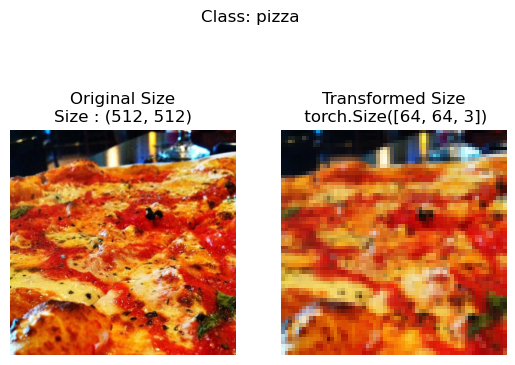

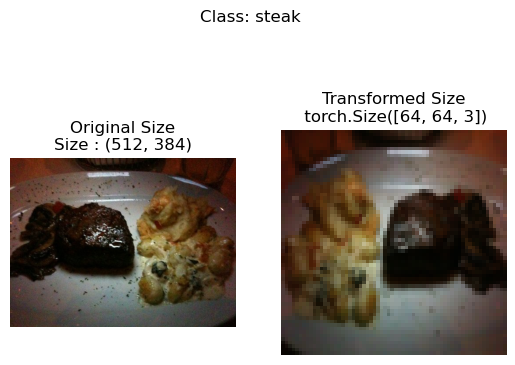

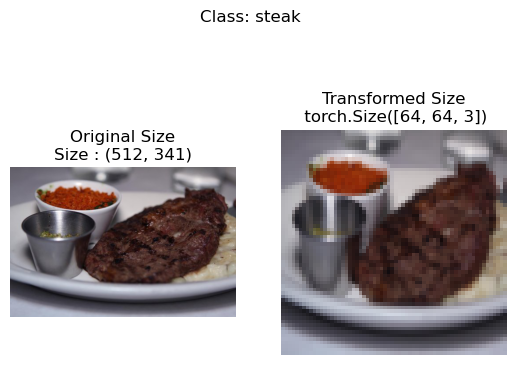

In [10]:
def plot_transformed_image(image_paths: list, transform, n=3, seed=None):
    """
    Selects random images from the path list of the image and loads/transforms
    them, then plots the orignal vs the transformed version.
    """

    if seed:
        random.seed(42)
    random_image_path = random.sample(image_paths, k=n) # gives n random paths

    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original Size\nSize : {f.size}')
            ax[0].axis(False)
            
            #transformed image
            transformed_image = transform(f).permute(1,2,0) # chw to hwc
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Size\n {transformed_image.shape}')
            ax[1].axis(False)

            fig.suptitle(f'Class: {image_path.parent.stem}')
            
plot_transformed_image(image_path_list, transform=data_transforms, seed=42)

## 4. Option 1: Loading all the images using `ImageFolder`

We can load image classification using `torchvision.datasets.ImageFolder`

We can use this because our folder is already in the standard image classification format.

train
'
'--pizza
    '
    '-<>.jpg
    '-<>.jpg
'--sushi
    '
    '-<>.jpg
    '-<>.jpg
'--steak
    '
    '-<>.jpg
    '-<>.jpg

In [11]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transforms,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 226
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# check the lengths of our datasets
len(train_data), len(test_data)

(226, 75)

In [15]:
# get one data
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

### 4.1. Visualize the data

In [16]:
# index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]

print(f'Image tensor:\n {img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Image label dtype: {type(label)}')

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original image shape: torch.Size([3, 64, 64])
Permuted image shape: torch.Size([64, 64, 3])


(-0.5, 63.5, 63.5, -0.5)

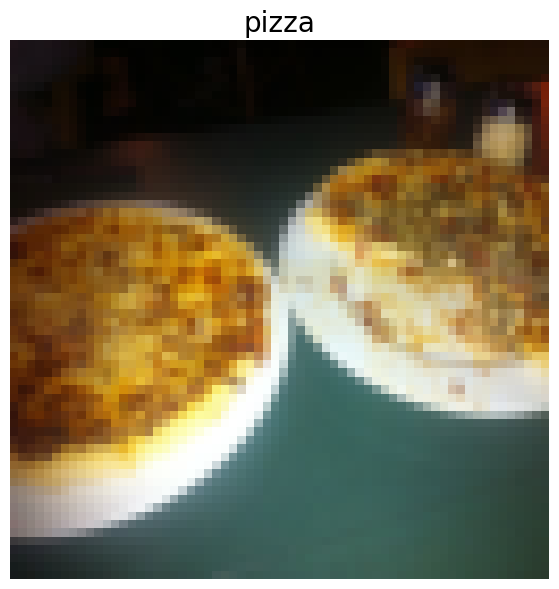

In [17]:
# to visualize the data, we have to change the order of the dimensions
# in matplotlib [hwc] not [chw]

img_permute = img.permute(1,2,0)

# Print out shapes: original and img_permute
print(f'Original image shape: {img.shape}')
print(f'Permuted image shape: {img_permute.shape}')

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize=20)
plt.axis(False)

### 4.2 Turn datasets into DataLoaders

Dataloader will turn our `datasets` into `iterables`. And we can customize the `batch_size`, so our model can see `batch_size` images at a time.

In [18]:
from torch.utils.data import DataLoader

import os
print(f'Total CPU: {os.cpu_count()}')

Total CPU: 16


In [19]:
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(), # the more the better
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size = BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x12714c6a0>,
 <torch.utils.data.dataloader.DataLoader at 0x12714ca60>)

In [20]:
# iterate through the dataloader
img, label = next(iter(train_dataloader))

# print img shape and label shape
print(f'Image Shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'Label Shape: {label.shape}')

Image Shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label Shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. To be able to load images from file
2. To be able to get class names from the Dataset
3. To be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` our of almost anything
* Not limited to PyTorch pre-buildt `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't nmean it will work.
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass `torch.utils.data.Dataset`

In [21]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [22]:
# instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Let's replicate this in our `Custom Dataset`

### 5.1. Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the direcotry structure)
3. Turn the class names into a dict and a list and return them.

In [23]:
# setup path for a target directory
target_directory = train_dir
print(f'Target Directory: {target_directory}')

# get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names

Target Directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [24]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [25]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str, int]]:
    """
    Finds the class folder names in a target directory
    """
    # 1. Get the class naes by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check the file structure.")

    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to replicate `ImageFolder`

We don't have to build this because PyTorch already have tried and tested class/method for this.

Build if we want anything custom we can build our own.

To create our own dataset, we want to:
1. `Subclass` `torch.utils.data.Dataset`
2. `__init__` our subclass with `target directory`--the directory we'd like to get data from--as well as a `transform` if we'd like to transform our data
3. Create several `attributes`
    - paths - paths of our images
    - transform - the transform we'd like to use
    - classes - a list of the target classes
    - classes_to_idx - a dict of the target classes mapped to integer labels
4. Create a `function` to `load_images()`, this function will open an image
5. `Override` the `__len__()` method to return the length of our dataset
6. `Override` the `__getitem()__` method to return a given sample when passed an index

In [26]:
# 0. write a custom dataset class
from torch.utils.data import Dataset

# 1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, 
                 targ_dir: str,
                 transform=None):
        # 3. create class atrributes
        # get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

        # setup transform
        self.transform = transform

        # create classes and class to index attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load image
    def _load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Override __len__()
    def __len__(self) -> int:
        """Returns the total number of samples"""
        return len(self.paths)

    # 6. Overrite __getitem()__ method to return particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data - data and label(X,y)"""
        img = self._load_image(index)
        class_name = self.paths[index].parent.name # expects file in format data_folder/class_name/name.jpg
        class_idx = self.class_to_idx[class_name]

        # transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data. label (X,y)
        return img, class_idx

In [27]:
# create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [28]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

train_data_custom.classes, test_data_custom.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [29]:
img, label = next(iter(train_data_custom))
img, label

(tensor([[[0.8863, 0.8980, 0.9020,  ..., 0.1294, 0.1333, 0.1255],
          [0.8941, 0.9020, 0.9098,  ..., 0.2039, 0.2039, 0.1961],
          [0.8980, 0.9020, 0.9059,  ..., 0.2902, 0.2667, 0.2627],
          ...,
          [0.4471, 0.4431, 0.4353,  ..., 0.0824, 0.0588, 0.0510],
          [0.4314, 0.4275, 0.4314,  ..., 0.0431, 0.0353, 0.0431],
          [0.4314, 0.4196, 0.4196,  ..., 0.0431, 0.0784, 0.1529]],
 
         [[0.8980, 0.9137, 0.9176,  ..., 0.0863, 0.0902, 0.0824],
          [0.9059, 0.9176, 0.9255,  ..., 0.1294, 0.1333, 0.1216],
          [0.9098, 0.9176, 0.9216,  ..., 0.1961, 0.1765, 0.1686],
          ...,
          [0.3333, 0.3412, 0.3373,  ..., 0.0863, 0.0588, 0.0510],
          [0.3216, 0.3294, 0.3333,  ..., 0.0431, 0.0431, 0.0471],
          [0.3137, 0.3255, 0.3294,  ..., 0.0431, 0.0706, 0.1216]],
 
         [[0.8314, 0.8510, 0.8588,  ..., 0.0510, 0.0510, 0.0431],
          [0.8353, 0.8588, 0.8667,  ..., 0.0824, 0.0824, 0.0745],
          [0.8353, 0.8588, 0.8667,  ...,

### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, let's cap the number of images to 10
3. Set the random seed for reproducibility
4. Get a list of random sample index from the target dataset
5. Setup a matplotlib plot
6. Loop throught the random sample images and plot them in matplotlib
7. Make sure the dimension of our images line up with matplotlib(hwc)

In [30]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[int] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting n to 10")

    # 3. set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k = n)

    # 5. Setup plot
    plt.figure(figsize=(16,8))
    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample_idx in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample_idx][0], dataset[targ_sample_idx][1]

        # 6. Adjust tensor dimensions for plotting
        targ_image_adust = targ_image.permute(1,2,0)

        # plot adjusted sample
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adust)
        plt.axis(False)
        if classes:
            title = f'Class: {classes[targ_label]}'
            if display_shape:
                title = title + f'\nshape: {targ_image_adust.shape}'
        plt.title(title)
        


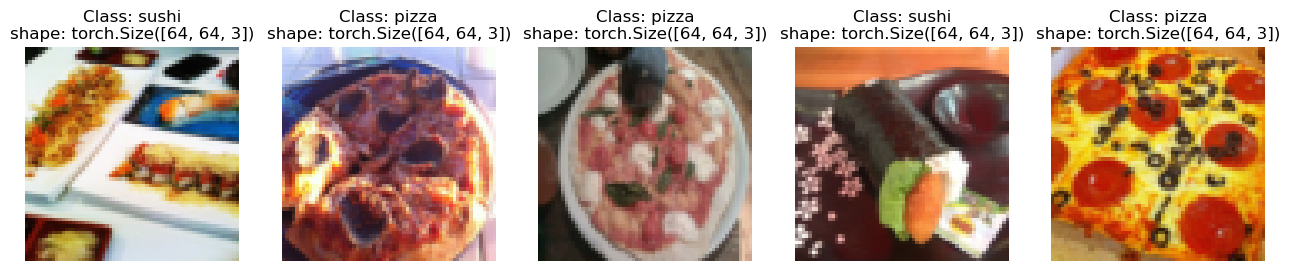

In [31]:
# display random images from the ImageFolder created Dataset

display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

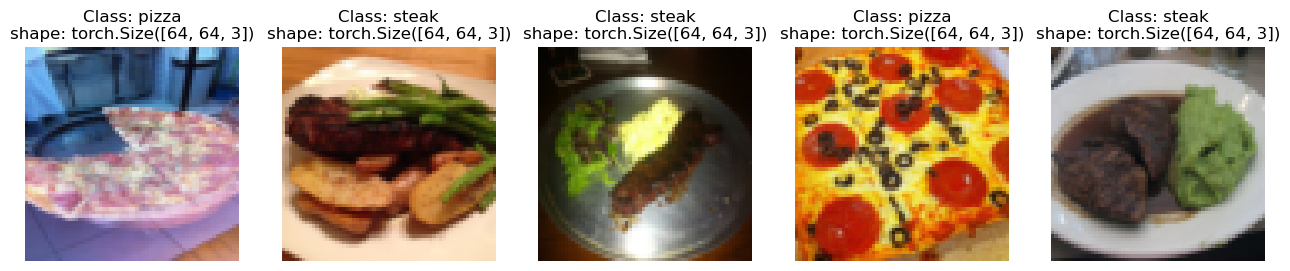

In [32]:
display_random_images(dataset=train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`

In [33]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
NUM_WORKERS = 0

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x12732a230>,
 <torch.utils.data.dataloader.DataLoader at 0x127316da0>)

In [34]:
# get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transform (data augmentation)

Data augmentation is the process of artificially adding diversity ot your training data.

In the ase of image data, this may mean applying various image transformations to the training images.

This practice hopefully results ina model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation -`TrivialAugment`- used to train PyTorch vision models to state of the art levels...

Blog Post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [35]:
# Let's look at trivial augment

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [36]:
# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

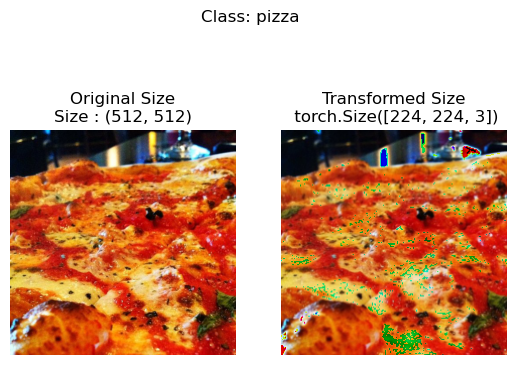

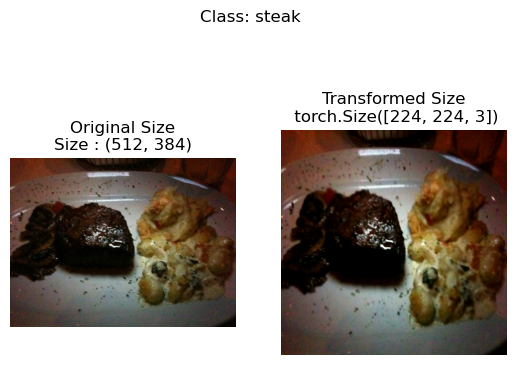

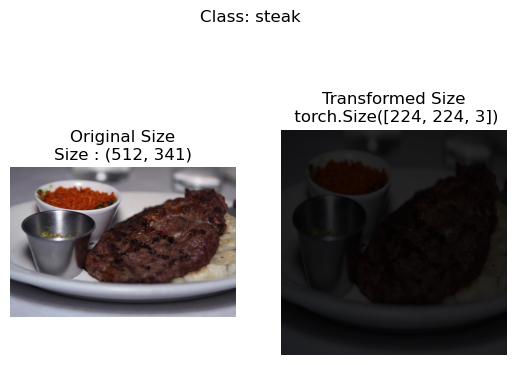

In [37]:
# plot random images
plot_transformed_image(image_paths=image_path_list,
                       transform=train_transforms,
                       n=3,
                       seed=42)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture fromt he CNN Explainer website:

### 7.1 Creating transforms and loading data for Model 0

In [38]:
# create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [39]:
from pathlib import Path
from torchvision import datasets

root_path = Path('data')
train_path = root_path / 'pizza_steak_sushi/train'
test_path = root_path / 'pizza_steak_sushi/test'

list(train_path.glob("*/*.jpg"))[:2]
# loading dataset
train_dataset = datasets.ImageFolder(root=train_path,
                                    transform=simple_transform,
                                    target_transform=None)
test_dataset = datasets.ImageFolder(root=train_path,
                                    transform=simple_transform,
                                    target_transform=None)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 226
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 226
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [40]:
# turning dataset into DataLoader
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)
train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x12732a020>,
 <torch.utils.data.dataloader.DataLoader at 0x127531e40>)

In [41]:
image, label = next(iter(train_dataloader_simple))
image.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 7.2 Create TinyVGG model class

In [42]:
from torch import nn
from torchvision import transforms

class TinyVGG(nn.Module):
    """
    """

    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv2d_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv2d_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # classifier layer
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv2d_block_1(x)
        # print(f'Output shape of block 1: {x.shape}')
        x = self.conv2d_block_2(x)
        # print(f'Output shape of block 2: {x.shape}')
        x = self.linear_layer(x)
        # print(f'Output shape of linear layer: {x.shape}')
        
        return x
        



In [43]:
class_names

['pizza', 'steak', 'sushi']

In [44]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names))
model_0

TinyVGG(
  (conv2d_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [45]:
### 7.3 Get a single image batch
# image_batch, label_batch = next(iter(train_dataloader))
# image_batch.shape, label_batch.shape

In [46]:
# try a forward pass
# model_0(image_batch)

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [47]:
from torchinfo import summary

summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Training and Test step

In [48]:
# setting loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr = 0.1
)

def accuracy_fn(y_pred, y_true):
    acc = (y_true==y_pred).sum().item() / len(y_pred)

    return acc

In [49]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device=device,
               accuracy_fn = None):
    train_loss, train_acc = 0,0
    for batch_size, (X, y) in enumerate(dataloader):
        # train loop
        model_0.train()

        # forward pass
        y_logits = model_0(X)
        # y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        
        # loss/optimzer
        loss = loss_fn(y_logits, y)
        train_acc += (y_pred_class == y).sum().item()/len(y_logits)
        # acc = accuracy_fn(y_pred_class, y)
        
        train_loss +=loss.item()
        # train_acc +=acc
        
        # zero grad
        optimizer.zero_grad()
        
        # loss backward
        loss.backward()
        # optimizer.step()
        optimizer.step()
        
    train_loss/=len(train_dataloader)
    train_acc/=len(train_dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device,
              accuracy_fn = None):
    # test loop
    model_0.eval()
    with torch.inference_mode():
        test_loss, test_acc = 0, 0
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_0(X)
            # test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
            test_pred_labels = test_logits.argmax(dim=1)
            
            loss = loss_fn(test_logits, y)
            # acc = accuracy_fn(test_pred, y)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            test_loss +=loss.item()
            # test_acc +=acc
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
        return test_loss, test_acc

In [50]:
from tqdm.auto import tqdm
NUM_EPOCHS = 5

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          device: torch.device = device,
          accuracy_fn = None):

    # Create empty result dictionary
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    # loop through training and testing stes for a number of epochs
    for epoch in tqdm(range(epochs)):
        print(f'Epoch: {epoch}\n----')
        train_loss, train_acc = train_step(model_0,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn=accuracy_fn)
    
        # test
        test_loss, test_acc = test_step(model_0, 
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn,
                                        accuracy_fn = accuracy_fn,
                                        device=device)
        print(f'Training loss: {train_loss:.5f} acc: {train_acc:.5f} | Testing loss: {test_loss:.5f} acc: {test_acc:.5f}')

        # update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    # return the results
    return results

### 7.7 Train and Evaluate Model 0 Output

In [51]:

from timeit import default_timer as timer

torch.manual_seed(42)
# define model
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names))

# setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr = 0.001
)

#setup accuracy fn
def accuracy_fn(y_pred, y_true):
    acc = (y_true==y_pred).sum().item() / len(y_pred)

    return acc

# setup start timer
start_timer = timer()

EPOCHS = 5
model_0_results = train(model_0,
                train_dataloader = train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=EPOCHS,
                accuracy_fn=accuracy_fn)
end_time = timer()

print(f'Total time taken: {(end_time - start_timer):.2f}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
----
Training loss: 1.10006 acc: 0.32743 | Testing loss: 1.09836 acc: 0.33333
Epoch: 1
----
Training loss: 1.09941 acc: 0.33186 | Testing loss: 1.09830 acc: 0.33333
Epoch: 2
----
Training loss: 1.09904 acc: 0.34513 | Testing loss: 1.09807 acc: 0.33333
Epoch: 3
----
Training loss: 1.09834 acc: 0.34513 | Testing loss: 1.09839 acc: 0.33333
Epoch: 4
----
Training loss: 1.09747 acc: 0.36283 | Testing loss: 1.09921 acc: 0.33333
Total time taken: 876.58


In [52]:
model_0_results

{'train_loss': [1.1000586679551454,
  1.099407392792997,
  1.0990402123569387,
  1.0983431784980064,
  1.0974705989381908],
 'train_acc': [0.3274336283185841,
  0.33185840707964603,
  0.34513274336283184,
  0.34513274336283184,
  0.36283185840707965],
 'test_loss': [1.0983601236343383,
  1.0982968060175577,
  1.0980710363388062,
  1.0983920669555665,
  1.0992137130101522],
 'test_acc': [0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333]}

### 7.8. Plot the loss curves of Model 0

In [53]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

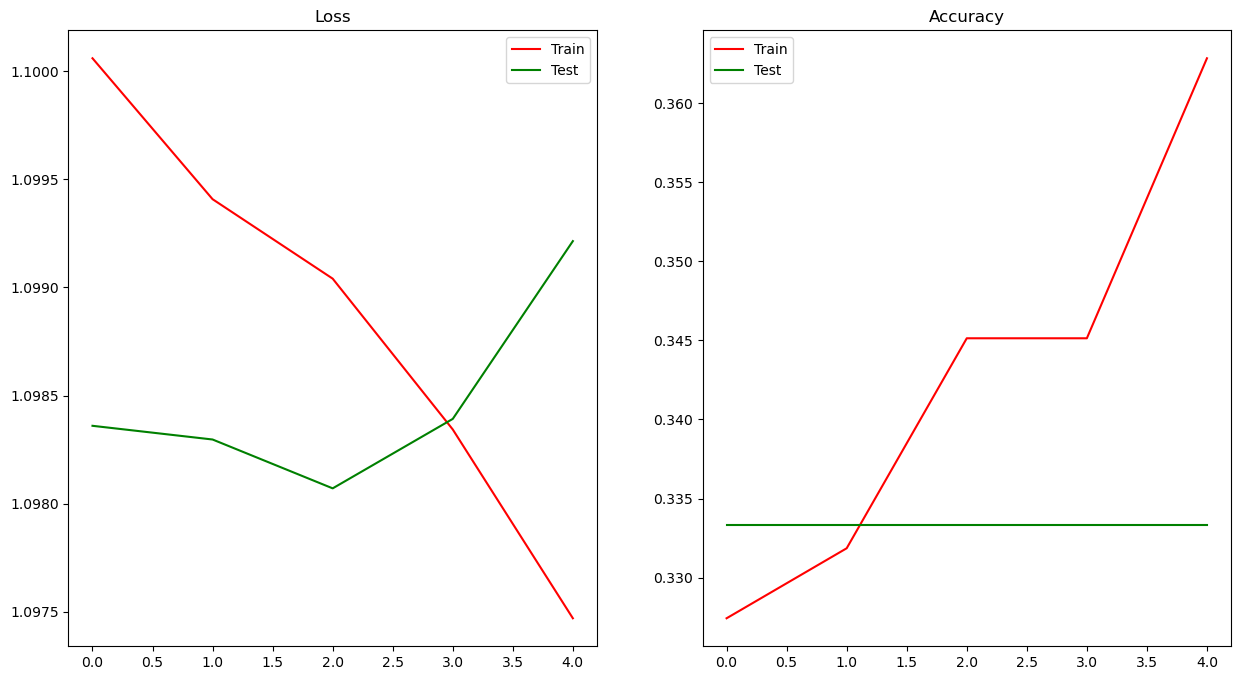

In [54]:
def plot_loss_curves(model_results: Dict[str, List[float]]):
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.plot(model_results['train_loss'], c='r', label='Train')
    plt.plot(model_results['test_loss'], c='g', label='Test')
    plt.legend()
    plt.title('Loss')
    
    plt.subplot(1,2,2)
    plt.plot(model_results['train_acc'], c='r', label='Train')
    plt.plot(model_results['test_acc'], c='g', label='Test')
    plt.legend()
    plt.title('Accuracy')

plot_loss_curves(model_0_results)

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modeling experiment. This time using the same model as before with some `data augmentation`

### 9.1 Create transform with data augmentation

In [55]:
import torch
from torch import nn
from torchvision import transforms

In [56]:
# Create training transform with TrivialAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Load data using the transform

In [57]:
from torchvision.datasets import ImageFolder

In [58]:
train_path

PosixPath('data/pizza_steak_sushi/train')

In [59]:
train_data_trivial = ImageFolder(root=train_path,
                                 transform=train_transform_trivial,
                                 target_transform=None)
test_data_simple = ImageFolder(root=test_path, 
                                transform=test_transform_simple,
                                target_transform=None)

train_data_trivial, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 226
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [60]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_augmented = DataLoader(dataset=train_data_trivial,
                                           batch_size = BATCH_SIZE,
                                           num_workers=os.cpu_count(),
                                           shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                           batch_size = BATCH_SIZE,
                                           num_workers=os.cpu_count(),
                                           shuffle=False) 

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x12831a2c0>,
 <torch.utils.data.dataloader.DataLoader at 0x12831b010>)

In [61]:
image, label = next(iter(train_dataloader_augmented))
image.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

(-0.5, 63.5, 63.5, -0.5)

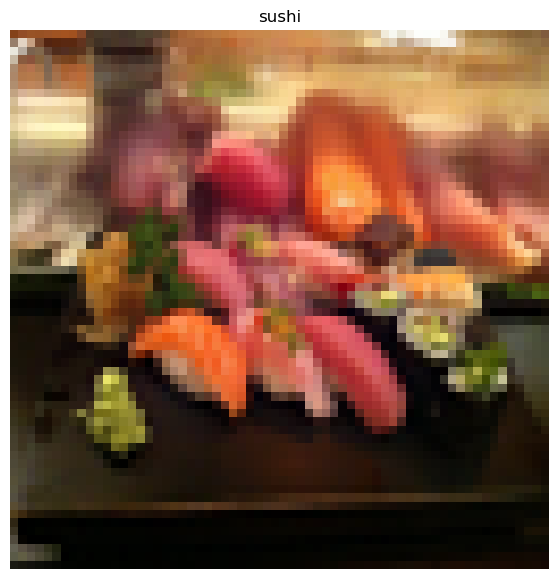

In [62]:
permuted_image = image[0].permute(1,2,0)
plt.figure(figsize=(10,7))
plt.imshow(permuted_image)
plt.title(class_names[label[0].item()])
plt.axis(False)

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data

In [63]:
# create model_1 and put it to the target device

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_trivial.classes))

model_1

TinyVGG(
  (conv2d_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [64]:
train_dataloader_augmented

Now, we've a model and a dataloaders.

Let's create a loss function and an optimer and call our `train()` method to train and evaluate our model

In [ ]:
# set random seeds
torch.manual_seed(42)

# set the number of epochs
NUM_EPOCHS = 5

# setup loss functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.001)

# start our timer
from timeit import default_timer as timer
start_time = timer()

# train model
model_1_results = train(model=model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        accuracy_fn=accuracy_fn,
                        loss_fn=loss_fn,
                        optimizer=optimizer,epochs=NUM_EPOCHS)
# end the timer
end_time = timer()

# print time
print(f'Total training time for model_1 {end_time-start_time:.2f} seconds')
                        

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
----


In [ ]:
model_1_results

## 10. Comprare model results

After evaluating our modeling expriments on their own, it's important to compare them to each other

There are few different ways to do this:
1. Hard coding( what we're doing right now)
2. PyTorch + Tensorboard
3. Weights and Biases
4. MLFlow

In [ ]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

In [ ]:
# setup a plot
plt.figure(figsize=(15,10))

# get the number of epochs
epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

# plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()

# plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Train Acc')
plt.xlabel('Epochs')
plt.legend()

# plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Test Acc')
plt.xlabel('Epochs')
plt.legend();

## 11. Making a prediction on a custom image

### 11.1. Getting the data

In [ ]:
# download custom image
import requests

# setup custom image path
custom_image_path = data_path / '04_pizza-data.jpeg'

# download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
        print(f'Downloading {custom_image_path}...')
        f.write(request.content)
        print('Done.')
else:
    print(f'{custom_image_path} already exist')


### 11.2. Loading the custom image with `PyTorch`

We have to make sure our custom image is in the same format as the data our model was trained on, i.e. PyTorch Tensor form
- In tensor form with datatype(torch.float32)
- of shape (64,64,3)
- on the right device

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f'Image Shpae: {custom_image_uint8.shape}')
print(f'Image dtype: {custom_image_uint8.dtype}')
print(f'Custom Image Tensor: {custom_image_uint8}')

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.3. Making a prediction on a custom image with a trained PyTorch Model

In [ ]:
# try to make a prediction on an image in uint8 format

model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8)

To fix this error, we have to convert `uint8` tensor to `torch.float32`

In [ ]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image.dtype

In [ ]:
# try to make a prediction on an image in torch.float32 format

model_1.eval()
with torch.inference_mode():
    model_1(custom_image)

We are getting this error because the shape of the input image is bigger that the image our model is expecting

Our model was trained on `(64,64)` but we have an image of `(4042,3024)`

So we have to change the shape of the image `(4042,3024) -> (64,64)`

In [ ]:
plt.imshow(custom_image.permute(1,2,0))

In [ ]:
# create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64), antialias=True)
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# print out the shapes
print(f'Shape of custom image: {custom_image.shape}')
print(f'Shape of transformed image: {custom_image_transformed.shape}')

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [150]:
# try to make a prediction on an transformed image in torch.float32 format 

model_1.eval()
with torch.inference_mode():
    model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

<div class='alert alert-danger'>
    We are getting this error because,
    
    we have to `add batch size` to the image shape
</div>

In [153]:
# add batch
custom_image_tranformed_batch = custom_image_transformed.unsqueeze(dim=0)
custom_image_tranformed_batch.shape

torch.Size([1, 3, 64, 64])

In [156]:
# final prediction

model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_tranformed_batch)
custom_image_pred

tensor([[-0.0051,  0.0280,  0.0421]])

***Note***

To make a prediction on a custom image we have to:
* `Load` the `image` and turn it into a `tensor`
* make sure the image was the `same datatype` as the model (torch.float32)
* make sure the image was the `same shape` as the data the model was trained on (3x64x64) with a `batch size -> (1, 3, 64, 64)`...
* make sure the image is in the `same device` as in the model

In [158]:
# convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3245, 0.3354, 0.3402]])

In [159]:
# convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

tensor([2])

In [162]:
class_names[custom_image_pred_labels]

'sushi'

### 11.4. Putting custom image prediction together: Building a function

tensor([[0.3245, 0.3354, 0.3402]])


'sushi'

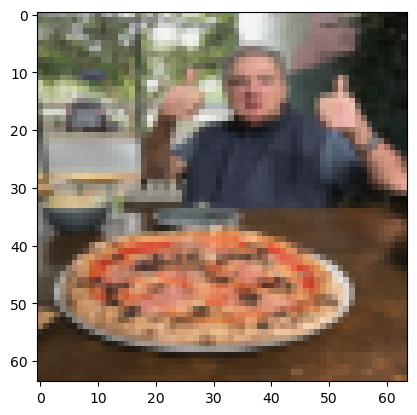

In [178]:
# def image_prediction(model: torch.nn.Module,
#                      image_path:str,
#                      class_names: List[str] = None,
#                     transform = None,
#                     device: torch.device = device):

def image_prediction(model: torch.nn.Module,
                     image_path:str,
                     transform_size: Tuple[int, int]):
    custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255

    image_transform = transforms.Compose([
        transforms.Resize(size=transform_size, antialias=True)
    ])
    custom_image = image_transform(custom_image)
    
    #plot the custom image
    plt.imshow(custom_image.permute(1,2,0))
    
    # add_batch
    custom_image = custom_image.unsqueeze(dim=0)
   

    # predict the image
    model.eval()
    with torch.inference_mode():
        prediction_logits = model(custom_image)
        pred_proba = torch.softmax(prediction_logits, dim=1)
        print(pred_proba)
        pred = torch.argmax(pred_proba, dim=1)

        return pred

result = image_prediction(model=model_1,
                 image_path = str(custom_image_path),
                 transform_size= (64,64))

class_names[result]